# 1. import lib & Load Dataset 

- mvcc : opencv를 대체하여 이미지를 열거나 처리하는 작업 
- mmdet.apis : Config파일을 이용하여 모델을 만들거나 inference 하는 작업을 수행 


In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

In [2]:
# !wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
# !unzip kitti_tiny.zip > /dev/null

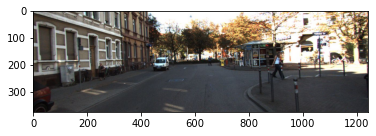

In [21]:
# imege Test
import matplotlib.pyplot as plt
import cv2

# 1. cv2.imread -> ndarray
# 2. bgr to rgb 
img = cv2.cvtColor(cv2.imread('kitti_tiny/training/image_2/000011.jpeg'), cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(15,10))
plt.imshow(img)

In [25]:
# Data Format 확인 - Label
!cat kitti_tiny/training/label_2/000011.txt

Pedestrian 0.00 1 0.30 883.68 144.15 937.35 259.01 1.90 0.42 1.04 5.06 1.43 12.42 0.68
Pedestrian 0.00 2 0.29 873.70 152.10 933.44 256.07 1.87 0.50 0.90 5.42 1.50 13.43 0.67
Car 0.00 0 1.74 444.29 171.04 504.95 225.82 1.86 1.57 3.83 -4.95 1.83 26.64 1.55
Pedestrian 0.00 0 -0.39 649.28 168.10 664.61 206.40 1.78 0.53 0.95 2.20 1.57 34.08 -0.33
Car 0.98 0 2.42 0.00 217.12 85.92 374.00 1.50 1.46 3.70 -5.12 1.85 4.13 1.56
Pedestrian 0.00 0 2.02 240.35 190.31 268.02 261.61 1.54 0.57 0.41 -7.92 1.94 15.95 1.57
DontCare -1 -1 -10 0.00 226.06 88.58 373.00 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 567.39 173.95 574.86 190.60 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 727.58 165.75 737.08 192.75 -1 -1 -1 -1000 -1000 -1000 -10


In [26]:
# Data Format 확인 - annotation image list
!cat kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


## 2. mmdetection의 중립 annotation 포맷으로 변환 

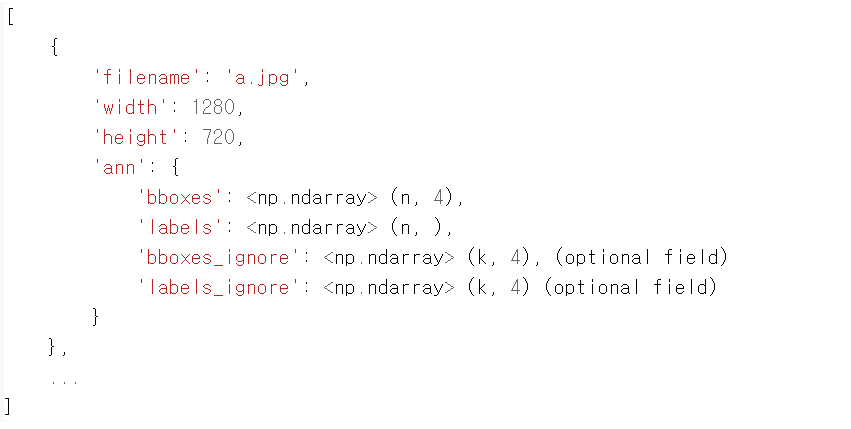

- filename : 경로는 포함하지 않고 이미지 파일명 
- width : 이미지 너비 
- height : 이미지 높이 
- ann : 해당 이미지의 bbox, labels등의 정보
* bboxes : 하나의 이미지에 있는 여러 Object 들의 bbox 좌표값( 좌상단, 우하단) - [n,4]
* labels : 하나의 이미지에 있는 여러 Object 들의 label - [n,]
* bboxes_ignore : 학습에 사용하지 않을 객체의 bbox 좌표(좌상, 우하) - [k,4]
* labels_ignore : 학습에 사용하지 않을 객체의 label - [k,]


In [28]:
# mmcv.list_from_file('경로') - txt 파일의 텍스트를 list로 가져옴 
train_list = mmcv.list_from_file('kitti_tiny/train.txt')

In [40]:
obj_list = set()
path = 'kitti_tiny/training/label_2/'
file_list = os.listdir(path)
# print(f"file_list: {file_list}")

for i in file_list:
    tmp = path+i
    with open(tmp,'r') as f:
        while True:
            line = f.readline()

            if not line:
                break
            
            obj = line.split()[0]
            obj_list.add(obj)

print("list of objects : ",obj_list)

list of objects :  {'Van', 'DontCare', 'Misc', 'Pedestrian', 'Person_sitting', 'Truck', 'Cyclist', 'Car', 'Tram'}


In [120]:
# mmdetection에서 사용할 수 있도록 우리의 데이터셋을 수정해 줘야 한다. Config 기반의 
# mmdetection에 개인 데이터셋을 사용하기 위해선 개인 데이터셋 또한 Config형태로 입력해 주어야 한다. 
# mmcv에는 알맞는 개인 데이터셋을 중립포맷으로 만들기위한 class를 형식에 맞춰서 입력하면 
# 개인 데이터셋이 mmdet에 알맞는 형식으로 config화 된다. 

# 이제 개인 데이터셋(kitti)를 mmdet의 중립 데이터셋 format으로 바꾸는 class를 만들어 보자!! 



import copy
import os.path as osp
import cv2
import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 데코레이터는 등록된 class나 함수(여기서는 아래 KittiTinyDataset)가 실행될 때, 
# 실행되기 전후로 특정한 기능을 하게 해주는 역할을 한다. 
# 여기서 개인 데이터셋이 중립데이터셋으로 바뀌기 위한 코드만 작성해 주면 나머지(Config로 변환하는)는
# 데코레이터부분에서 처리되므로 굉장히 간딴!!! 

@DATASETS.register_module(force=True)
class KittiTinyDataset(CustomDataset):
  CLASSES = ('Van', 'DontCare', 'Misc', 'Pedestrian', 'Person_sitting', 'Truck', 'Cyclist', 'Car', 'Tram')
  

  # load_annotation함수를 꼭 만들어줘야함! 
  # 데코레이터를 통해 이 class가 수행될때, 경로를 참고하여 이 함수가 실행됨 
  # 이 함수의 내용은 중립 데이터셋 format으로 변환하는 모든 내용이 담겨있어야 함 
  # ann_flile은 train/val/test 이미지의 목록이 들어있는 파일임 

  def load_annotations(self,ann_file):
    
    # category to label dict 생성 
    cat2label = {k:i for i,k in enumerate(self.CLASSES)}
    
    # 해당 file안의 string을 list로 가져옴  
    image_list = mmcv.list_from_file(self.ann_file)
  
    # 중립 데이터셋을 list 객체 생성 
    data_infos = []

    


    for image_id in image_list: 
      
      #이미지 경로 저장
      img_path = self.img_prefix+'/' + image_id + '.jpeg'
      
      # 이미지 읽기 및 정보 가져오기 [ 높이, 너비 ]
      image = cv2.imread(img_path)
      height, width = image.shape[:2]
      data_info = {'filename':str(image_id)+'.jpeg','width':width,'height':height}

      # 이제 label에서 정보를 가져와 보자! 
      label_prefix = self.img_prefix.replace('image_2','label_2')

      # 해당 이미지에 맞는 label 파일에 접근하여 정보를 가져옴 
      # 아래 결과는 label_prefix/image_id.txt임 
      lines = mmcv.list_from_file(osp.join(label_prefix,str(image_id)+'.txt'))  
      content = [line.strip().split(' ') for line in lines] # [객체 수, 15]

      # object의 클래스명을 저장 
      bbox_names = [x[0] for x in content]

      # bbox 의 좌표를 저장 
      bboxes = [ [float(info) for info in x[4:8]] for x in content]
      # bboxes = [list(map(float,x[4,8])) for x in content]

      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      # 위에서 설정한 bbox_name과 bbox좌표를 zip을 통해 병렬식으로 꺼낸후 처리함
      # 여기서 처리하는 것은 ignore할 object를 따로 분류하는 작업을 함 
      for bbox_name, bbox in zip(bbox_names, bboxes):

        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          gt_labels.append(cat2label[bbox_name])

        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(cat2label[bbox_name])

      # for문이 끝난 후, bbox와 label을 등록함 
      data_anno = {
        'bboxes': np.array(gt_bboxes,dtype=np.float32).reshape(-1,4),
        'labels': np.array(gt_labels,dtype=np.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1,4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }

      # dict.update(key=value)를 이용하여 이전에 만든 data_info에 업데이트 함. 
      data_info.update(ann=data_anno)
      
      # 전체 정보를 모아둔 list에 한 이미지의 정보를 모든 dict를 append하여 모은다. 
      data_infos.append(data_info)
    
    return data_infos 
  


        
      

## 3. Config 설정

In [121]:
# Config 파일 설정 - faster RCNN / ResNet50 / FPN / 12epoch / pretrained on CoCodataset 
config_file = 'mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'

# 사전학습된 가중치 업로드 
checkpoint_file = 'mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

## 4. 본격적인 Config를 통한 Dataset, Model 및 hyperparameter 적용 

In [122]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [123]:
cfg.keys()

dict_keys(['model', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'evaluation', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'opencv_num_threads', 'mp_start_method', 'auto_scale_lr'])

In [124]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 9
# pretrained 모델
cfg.load_from = checkpoint_file
                

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [140]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
train_datasets = [build_dataset(cfg.data.train)]
# test_datasets = [build_dataset(cfg.data.test)]
val_datasets = [build_dataset(cfg.data.val)]

/tmp/ipykernel_2968/3764570409.py:93: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'labels': np.array(gt_labels,dtype=np.long),
/tmp/ipykernel_2968/3764570409.py:95: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for wh

In [141]:
val_datasets

[
 KittiTinyDataset Train dataset with number of images 25, and instance counts: 
 +-----------+-------+--------------+-------+----------+-------+----------------+-------+--------------------+-------+
 | category  | count | category     | count | category | count | category       | count | category           | count |
 +-----------+-------+--------------+-------+----------+-------+----------------+-------+--------------------+-------+
 | 0 [Van]   | 11    | 1 [DontCare] | 43    | 2 [Misc] | 1     | 3 [Pedestrian] | 13    | 4 [Person_sitting] | 5     |
 | 5 [Truck] | 3     | 6 [Cyclist]  | 7     | 7 [Car]  | 62    | 8 [Tram]       | 5     | -1 background      | 0     |
 +-----------+-------+--------------+-------+----------+-------+----------------+-------+--------------------+-------+]

In [137]:
train_datasets[0].CLASSES

('Van',
 'DontCare',
 'Misc',
 'Pedestrian',
 'Person_sitting',
 'Truck',
 'Cyclist',
 'Car',
 'Tram')

In [139]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = train_datasets[0].CLASSES

In [144]:
cfg.device = 'cuda'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, train_datasets, cfg, distributed=False, validate=True)

2022-05-10 21:06:25,045 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/tmp/ipykernel_2968/3764570409.py:93: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'labels': np.array(gt_labels,dtype=np.long),
/tmp/ipykernel_2968/3764570409.py:95: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 22.2 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-05-10 21:07:53,559 - mmdet - INFO - 
+----------------+-----+------+--------+-------+
| class          | gts | dets | recall | ap    |
+----------------+-----+------+--------+-------+
| Van            | 11  | 30   | 0.636  | 0.305 |
| DontCare       | 43  | 404  | 0.465  | 0.050 |
| Misc           | 1   | 5    | 0.000  | 0.000 |
| Pedestrian     | 13  | 54   | 0.846  | 0.698 |
| Person_sitting | 5   | 0    | 0.000  | 0.000 |
| Truck          | 3   | 21   | 1.000  | 0.643 |
| Cyclist        | 7   | 38   | 0.571  | 0.085 |
| Car            | 62  | 146  | 0.952  | 0.862 |
| Tram           | 5   | 11   | 0.200  | 0.050 |
+----------------+-----+------+--------+-------+
| mAP            |     |      |        | 0.299 |
+----------------+-----+------+--------+-------+
2022-05-10 21:07:53,608 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.2990, mAP: 0.2991


9


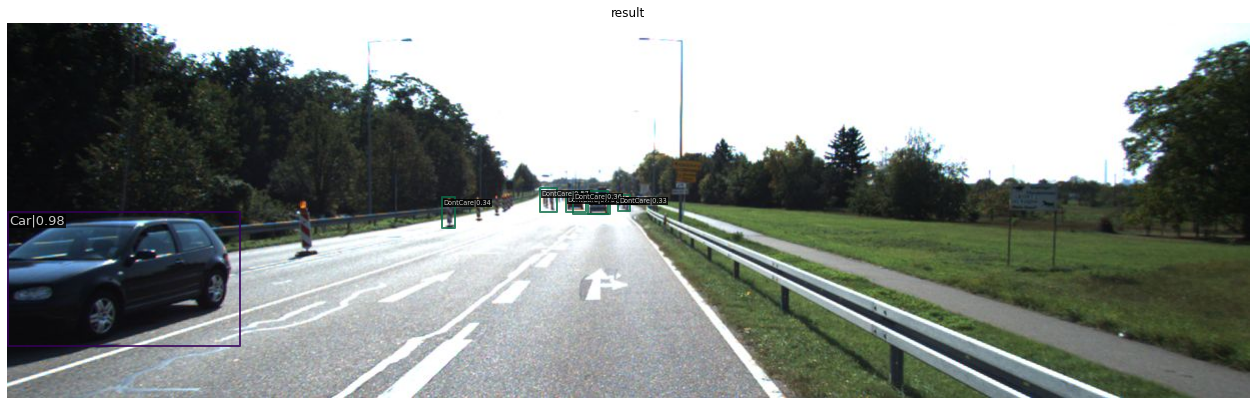

In [160]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('kitti_tiny/training/image_2/000033.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
print(len(result))
show_result_pyplot(model, img, result)

In [161]:
CLASSES = ('Van', 'DontCare', 'Misc', 'Pedestrian', 'Person_sitting', 'Truck', 'Cyclist', 'Car', 'Tram')
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}
labels_to_names_seq

{0: 'Van',
 1: 'DontCare',
 2: 'Misc',
 3: 'Pedestrian',
 4: 'Person_sitting',
 5: 'Truck',
 6: 'Cyclist',
 7: 'Car',
 8: 'Tram'}

In [162]:
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(result) == 0:
      continue
    
    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외. 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출. 
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [163]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [164]:
do_detected_video(model, 'data/the_rock_chase.mp4', 'data/the_rock_chase_c_9.mp4', score_threshold=0.4, do_print=True)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


총 Frame 갯수: 503
frame별 detection 수행 시간: 0.0663
frame별 detection 수행 시간: 0.0555
frame별 detection 수행 시간: 0.0536
frame별 detection 수행 시간: 0.0557
frame별 detection 수행 시간: 0.0553
frame별 detection 수행 시간: 0.0535
frame별 detection 수행 시간: 0.0526
frame별 detection 수행 시간: 0.0529
frame별 detection 수행 시간: 0.0516
frame별 detection 수행 시간: 0.0515
frame별 detection 수행 시간: 0.0516
frame별 detection 수행 시간: 0.0519
frame별 detection 수행 시간: 0.0518
frame별 detection 수행 시간: 0.0517
frame별 detection 수행 시간: 0.0522
frame별 detection 수행 시간: 0.0539
frame별 detection 수행 시간: 0.0521
frame별 detection 수행 시간: 0.0516
frame별 detection 수행 시간: 0.0513
frame별 detection 수행 시간: 0.0513
frame별 detection 수행 시간: 0.0525
frame별 detection 수행 시간: 0.0519
frame별 detection 수행 시간: 0.0524
frame별 detection 수행 시간: 0.0517
frame별 detection 수행 시간: 0.0522
frame별 detection 수행 시간: 0.0516
frame별 detection 수행 시간: 0.0533
frame별 detection 수행 시간: 0.0525
frame별 detection 수행 시간: 0.0529
frame별 detection 수행 시간: 0.0533
frame별 detection 수행 시간: 0.0528
frame별 detection 수행 시간: